# Database examples for Scott

### Connect notebook to database

We'll use the ipython-sql modules for convenient access from the notebook, and a database file in the current directory named "scottdb.sqlite".

In [1]:
%load_ext sql
%sql sqlite:///scottdb.sqlite

### Create database tables

In [2]:
%%sql

DROP TABLE IF EXISTS GamePlays;
DROP TABLE IF EXISTS Games;

CREATE TABLE Games (
   ID INTEGER NOT NULL PRIMARY KEY,
   Game TEXT,
   Version TEXT,
   Barcode TEXT,
   MAC TEXT,
   IP TEXT,
   Location TEXT
);

CREATE TABLE GamePlays (
   GameID INTEGER REFERENCES Games,
   players INTEGER,
   p1_fire INTEGER,
   p2_fire INTEGER,
   playtime INTEGER,
   pwr_plays INTEGER,
   p1_pwr_plays INTEGER,
   p2_pwr_plays INTEGER,
   Timestamp DATETIME NOT NULL DEFAULT CURRENT_TIMESTAMP      
);

 * sqlite:///scottdb.sqlite
Done.
Done.
Done.
Done.


[]

### Insert some data

This uses the "sqlalchemy" Python module which (more or less) automatically creates a bridge between Python objects and the database.  We insert a few example Games, and 10,000 random GamePlays in year 2021.

In [3]:
from random import *
from datetime import *

import sqlalchemy as sa

eng = sa.create_engine('sqlite:///scottdb.sqlite')
meta = sa.MetaData()
meta.reflect(bind=eng)

Games = meta.tables['Games']
GamePlays = meta.tables['GamePlays']

exampleGames = [
    { 'ID':1, 'Game':'Some Game',    'Version':'1.0', 'Barcode':'1234567', 'MAC':'aabbccaabbcc', 'IP':'192.168.0.10', 'Location':'Garage'  },
    { 'ID':2, 'Game':'Another Game', 'Version':'1.1', 'Barcode':'2345678', 'MAC':'bbccaabbccaa', 'IP':'192.168.0.11', 'Location':'Garage'  },
    { 'ID':3, 'Game':'Cool Game',    'Version':'1.0', 'Barcode':'3456789', 'MAC':'ccaabbccaabb', 'IP':'192.168.0.12', 'Location':'Garage'  },
    { 'ID':4, 'Game':'Lame Game',    'Version':'2.0', 'Barcode':'4567890', 'MAC':'aaccbbaaccbb', 'IP':'192.168.1.10', 'Location':'Barcade' },
    { 'ID':5, 'Game':'Fave Game',    'Version':'3.0', 'Barcode':'5678901', 'MAC':'ccbbaaccbbaa', 'IP':'192.168.1.11', 'Location':'Barcade' }
]

examplePlays = []
for i in range(10000):
    examplePlays.append({
        'GameID':    randint(1,5),
        'players':   randint(1,2),
        'playtime':  randint(10,300),
        'Timestamp': datetime(2021,1,1)+timedelta(days=randrange(365), minutes=randrange(24*60))
    })


with eng.connect() as con:
    con.execute(Games.insert().values(exampleGames))    
    con.execute(GamePlays.insert().values(examplePlays))

### Inspect the generated data

In [4]:
%sql SELECT * FROM Games

 * sqlite:///scottdb.sqlite
Done.


ID,Game,Version,Barcode,MAC,IP,Location
1,Some Game,1.0,1234567,aabbccaabbcc,192.168.0.10,Garage
2,Another Game,1.1,2345678,bbccaabbccaa,192.168.0.11,Garage
3,Cool Game,1.0,3456789,ccaabbccaabb,192.168.0.12,Garage
4,Lame Game,2.0,4567890,aaccbbaaccbb,192.168.1.10,Barcade
5,Fave Game,3.0,5678901,ccbbaaccbbaa,192.168.1.11,Barcade


In [5]:
%sql SELECT * FROM GamePlays LIMIT 10

 * sqlite:///scottdb.sqlite
Done.


GameID,players,p1_fire,p2_fire,playtime,pwr_plays,p1_pwr_plays,p2_pwr_plays,Timestamp
2,2,None,None,183,None,None,None,2021-12-09 21:17:00.000000
4,2,None,None,253,None,None,None,2021-12-10 00:41:00.000000
2,1,None,None,200,None,None,None,2021-08-27 20:16:00.000000
4,1,None,None,163,None,None,None,2021-09-01 15:07:00.000000
2,1,None,None,195,None,None,None,2021-06-07 04:03:00.000000
5,1,None,None,161,None,None,None,2021-01-14 22:19:00.000000
2,1,None,None,48,None,None,None,2021-01-28 08:57:00.000000
1,2,None,None,116,None,None,None,2021-12-20 03:40:00.000000
5,2,None,None,129,None,None,None,2021-08-09 22:00:00.000000
5,2,None,None,68,None,None,None,2021-08-04 09:38:00.000000


## Query: plays per game on a given day

In [6]:
%%sql
SELECT Game, COUNT(*) AS Plays
FROM Gameplays JOIN Games ON GamePlays.GameID = Games.ID
WHERE DATE(Timestamp) = '2021-05-01'
GROUP BY Game
ORDER BY Plays DESC

 * sqlite:///scottdb.sqlite
Done.


Game,Plays
Lame Game,8
Cool Game,8
Another Game,5
Fave Game,4
Some Game,3


<AxesSubplot:title={'center':'Plays on 2021-05-01'}, xlabel='Game'>

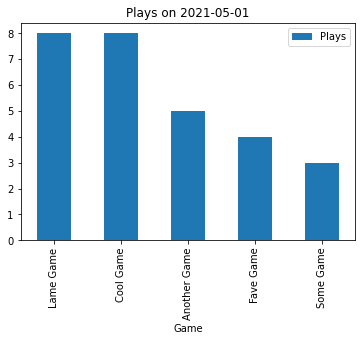

In [7]:
_.DataFrame().plot.bar(x='Game', y='Plays', title="Plays on 2021-05-01")

## Query: Plays per game on a given day, playtime >= 20 seconds

In [8]:
%%sql
SELECT Game, COUNT(*) AS Plays
FROM Gameplays JOIN Games ON GamePlays.GameID = Games.ID
WHERE DATE(Timestamp) = '2021-05-01' AND playtime >= 20
GROUP BY Game
ORDER BY Plays DESC

 * sqlite:///scottdb.sqlite
Done.


Game,Plays
Lame Game,8
Cool Game,8
Another Game,5
Fave Game,4
Some Game,3


<AxesSubplot:title={'center':'Plays (at least 20s) on 2021-05-01'}, xlabel='Game'>

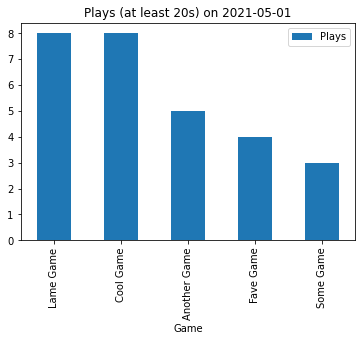

In [9]:
_.DataFrame().plot.bar(x='Game', y='Plays', title="Plays (at least 20s) on 2021-05-01")

## Query: plays per game on a given week

In [10]:
%%sql
SELECT Game, COUNT(*) AS Plays
FROM Gameplays JOIN Games ON GamePlays.GameID = Games.ID
WHERE strftime('%W', Timestamp) = '17'
GROUP BY Game
ORDER BY Plays DESC

 * sqlite:///scottdb.sqlite
Done.


Game,Plays
Another Game,49
Fave Game,42
Lame Game,40
Cool Game,40
Some Game,36


<AxesSubplot:title={'center':'Plays during 2021 week 17'}, xlabel='Game'>

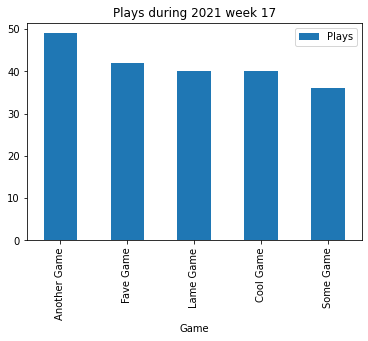

In [11]:
_.DataFrame().plot.bar(x='Game', y='Plays', title="Plays during 2021 week 17")

## Query: plays for particular game over a given month

In [12]:
%%sql
SELECT CAST(strftime('%d', Timestamp) AS INT) as Day, COUNT(*) AS Plays
FROM Gameplays
WHERE GameID=5 AND strftime('%m', Timestamp) = '04'
GROUP BY day
ORDER BY day

 * sqlite:///scottdb.sqlite
Done.


Day,Plays
1,3
2,5
3,7
4,8
5,8
6,5
7,6
8,8
9,4
10,7


<AxesSubplot:title={'center':'Plays of Fave Game during April 2021'}, xlabel='Day'>

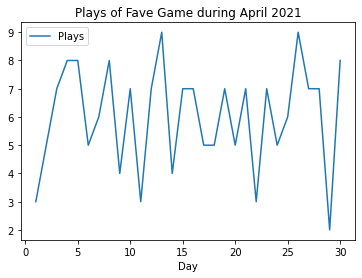

In [13]:
_.DataFrame().plot(x='Day', y='Plays', title='Plays of Fave Game during April 2021')